<a href="https://colab.research.google.com/github/UTKARSH4/Transformers-Model/blob/main/Transformers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [42]:
import pandas as pd
data=[]

## content of data
data_cont=[]
count = len(open('partial-labeled.txt').readlines(  ))
with open('partial-labeled.txt','r') as f:
  for i in range(count):
    data.append(f.readline().split('\t'))
  
x=pd.DataFrame(data=data)
x.columns = x.iloc[0]
new_data = x.iloc[1:]

In [36]:
import re
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

def preprocess(sentence):

  
  ps = WordNetLemmatizer()
  sentence = sentence.replace("\\n",' ')
  review_text = re.sub('[^a-zA-Z]', ' ', sentence)
  review_text = review_text.lower()
  review_text = review_text.split()
  review_text = [ps.lemmatize(word) for word in review_text if not word in set(stopwords.words('english'))]
  review_text = [word for word in review_text if len(word)>2]
  " ".join(review_text)

  return review_text




[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [47]:
new_data['Mail Body'] = new_data['Mail Body'].apply(preprocess)



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [48]:
new_data['Mail Body']

1     [dear, away, november, december, please, conta...
2     [office, starting, return, respond, message, r...
3     [contacting, life, technology, apore, request,...
4     [contacting, life, technology, apore, request,...
5     [office, monday, november, please, contact, oh...
6     [hello, office, return, monday, november, limi...
7     [following, service, request, assigned, accoun...
8     [please, click, link, view, updated, service, ...
9     [please, click, link, view, updated, service, ...
10    [recipient, could, processed, would, violate, ...
11                                                   []
12    [dear, best, regard, umc, kaex, lssfpjr, anh, ...
13    [dear, awfy, helpful, information, pick, one, ...
14    [replacement, done, ref, warmest, regard, bwa,...
15    [dear, yjln, taqman, snp, typing, assay, poor,...
16    [atal, based, info, inspector, link, upload, c...
17    [iwtjpdi, kindly, see, low, quality, run, turn...
18    [rbjse, lufio, pkqeting, application, mana

In [61]:
tfdata = tf.data.TextLineDataset(["partial-labeled.txt"])

In [84]:
def dataset_fn(ds):
  return ds.split('\t')

new_x=[element.decode('utf-8').split('\t') for element in tfdata.as_numpy_iterator()]
tfx=pd.DataFrame(data=new_x) 
tfx.columns=[tfx.iloc[0]]
tfnew_data=x.iloc[1:] 

In [54]:
import tensorflow as tf
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
import tensorflow_text as text
import numpy as np

In [12]:
import collections
import logging
import os
import pathlib
import re
import string
import sys
import time

import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds
import tensorflow_text as text
import tensorflow as tf

In [13]:
examples, metadata = tfds.load('ted_hrlr_translate/pt_to_en', with_info=True,
                               as_supervised=True)
train_examples, val_examples =examples['train'], examples['validation']

Shuffling and writing examples to /root/tensorflow_datasets/ted_hrlr_translate/pt_to_en/1.0.0.incomplete6SJQMC/ted_hrlr_translate-train.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/ted_hrlr_translate/pt_to_en/1.0.0.incomplete6SJQMC/ted_hrlr_translate-validation.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/ted_hrlr_translate/pt_to_en/1.0.0.incomplete6SJQMC/ted_hrlr_translate-test.tfrecord


Dataset ted_hrlr_translate downloaded and prepared to /root/tensorflow_datasets/ted_hrlr_translate/pt_to_en/1.0.0. Subsequent calls will reuse this data.


In [14]:
for pt_examples, en_examples in train_examples.batch(3).take(1):
  for pt in pt_examples.numpy():
    print(pt.decode('utf-8'))

  print()

  for en in en_examples.numpy():
    print(en.decode('utf-8'))

e quando melhoramos a procura , tiramos a única vantagem da impressão , que é a serendipidade .
mas e se estes fatores fossem ativos ?
mas eles não tinham a curiosidade de me testar .

and when you improve searchability , you actually take away the one advantage of print , which is serendipity .
but what if it were active ?
but they did n't test for curiosity .


In [16]:
model_name = "ted_hrlr_translate_pt_en_converter"
tf.keras.utils.get_file(
    f"{model_name}.zip",
    f"https://storage.googleapis.com/download.tensorflow.org/models/{model_name}.zip",
    cache_dir='.', cache_subdir='', extract=True
)
tokenizers = tf.saved_model.load(model_name)
[item for item in dir(tokenizers.en) if not item.startswith('_')]

188416/184801 [==============================] - 0s 0us/step


['detokenize',
 'get_reserved_tokens',
 'get_vocab_path',
 'get_vocab_size',
 'lookup',
 'tokenize',
 'tokenizer',
 'vocab']

In [17]:
def tokenize_pairs(pt, en):
    pt = tokenizers.pt.tokenize(pt)
    # Convert from ragged to dense, padding with zeros.
    pt = pt.to_tensor()

    en = tokenizers.en.tokenize(en)
    # Convert from ragged to dense, padding with zeros.
    en = en.to_tensor()
    return pt, en

In [18]:
BUFFER_SIZE = 20000
BATCH_SIZE = 64

def make_batches(ds):
  return (
      ds
      .cache()
      .shuffle(BUFFER_SIZE)
      .batch(BATCH_SIZE)
      .map(tokenize_pairs, num_parallel_calls=tf.data.AUTOTUNE)
      .prefetch(tf.data.AUTOTUNE))

train_batches = make_batches(train_examples)
val_batches = make_batches(val_examples)

In [19]:
def get_angles(pos, i, d_model):
  angle_rates = 1 / np.power(10000, (2 * (i//2)) / np.float32(d_model))
  return pos * angle_rates


In [20]:
def positionalencoding(position,d_model):

  angle_rads = get_angles(np.arange(position)[:, np.newaxis],
                          np.arange(d_model)[np.newaxis, :],
                          d_model)

  # apply sin to even indices in the array; 2i
  angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])

  # apply cos to odd indices in the array; 2i+1
  angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])

  pos_encoding = angle_rads[np.newaxis, ...]

  return tf.cast(pos_encoding, dtype=tf.float32)



In [21]:
def create_look_ahead_mask(size):
  mask = 1 - tf.linalg.band_part(tf.ones((size, size)), -1, 0)
  return mask  # (seq_len, seq_len)

In [22]:
def scaleddotproductattention(K,Q,V,mask):

  dotproduct = np.matmul(K,Q, transpose_b=True)
  dk = tf.cast(tf.shape(K)[-1],dtype=tf.float32)
  scaledweights = dotproduct/tf.math.sqrt(dk)

  if mask is not None :
    scaledweights += (mask * -1e9)
  weights=tf.nn.softmax(scaledweights,axis=-1)
  output=np.matlmul(weights,V)

  return output,weights


In [23]:
class MultiHeadAttention(tf.keras.layers.Layer):

  def __init__(self, d_model, num_heads):

    super(MultiHeadAttention, self).__init__()
    self.d_model = d_model
    self.num_heads = num_heads

    assert d_model % self.num_heads == 0

    self.depth = d_model

    self.K = tf.keras.layers.Dense(d_model)
    self.Q = tf.keras.layers.Dense(d_model)
    self.V = tf.keras.layers.Dense(d_model)
    self.out9 = tf.keras.layers.Dense(d_model)

  def split_heads(self, x, batch_size):

    x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
    return tf.transpose(x, perm=[0, 2, 1, 3])

  def call(self,k,q,v,mask):
    
    batch_size = tf.shape(q)[0]
    k = self.K(k)
    q = self.Q(q)
    v = self.V(v)

    k = self.split_heads(q, batch_size)  
    q = self.split_heads(k, batch_size)  
    v = self.split_heads(v, batch_size)

    output,weights = scaleddotproductattention(k,q,v,mask)

    scaled_attention = tf.transpose(output, perm=[0, 2, 1, 3])
    concate_attention =  tf.reshape(scaled_attention,(batch_size,-1,d_model))
    out = self.out9(concate_attention)

    return out, attention_weights


In [24]:
def point_wise_feed_forward_network(d_model, dff):
  return tf.keras.Sequential([
      tf.keras.layers.Dense(dff, activation='relu'),  
      tf.keras.layers.Dense(d_model)  
  ])

In [25]:
class EncoderLayer(tf.keras.layers.Layer):
  def __init__(self, d_model, num_heads, dff, rate=0.1):
    super(EncoderLayer, self).__init__()

    self.mha = MultiHeadAttention(d_model, num_heads)
    self.ffn = point_wise_feed_forward_network(d_model, dff)

    self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

    self.dropout1 = tf.keras.layers.Dropout(rate)
    self.dropout2 = tf.keras.layers.Dropout(rate)

  def call(self, x, training, mask):

    attn_output, _ = self.mha(x, x, x, mask)  # (batch_size, input_seq_len, d_model)
    attn_output = self.dropout1(attn_output, training=training)
    out1 = self.layernorm1(x + attn_output)  # (batch_size, input_seq_len, d_model)

    ffn_output = self.ffn(out1)  # (batch_size, input_seq_len, d_model)
    ffn_output = self.dropout2(ffn_output, training=training)
    out2 = self.layernorm2(out1 + ffn_output)  # (batch_size, input_seq_len, d_model)

    return out2

In [26]:
class decoder_layer(tf.keras.layers.Layer):
  def __init__(self, d_model, num_heads, dff, rate=0.1):
    super(decoder_layer,self).__init__()

    self.mha1 = MultiHeadAttention(d_model, num_heads)
    self.mha2 = MultiHeadAttention(d_model, num_heads)

    self.ffn = point_wise_feed_forward_network(d_model, dff)

    self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    self.layernorm3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

    self.dropout1 = tf.keras.layers.Dropout(rate)
    self.dropout2 = tf.keras.layers.Dropout(rate)
    self.dropout3 = tf.keras.layers.Dropout(rate)

  def call(self, x, training, mask, look_ahead_mask, enc_output):
    MultiAttention,_ = self.mha1(x, x, x, look_ahead_mask)
    drop1 = self.dropout1(MultiAttention, training=training)
    norm1 = self.layernorm1(x + drop1)

    MultiAttention1,_ = self.mha2( enc_output,  enc_output, norm1, mask)
    drop2 = self.dropout2(MultiAttention1, training=training)
    norm2 = self.layernorm2(MultiAttention1 + drop2)

    ffn_output = self.ffn(norm2)
    drop3 = self.dropout2(ffn_output, training=training)
    norm3 = self.layernorm2(ffn_output + drop3)

    return norm3

In [27]:
class Encoder(tf.keras.layers.Layer):
  def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size,
               maximum_position_encoding, rate=0.1):
    super(Encoder, self).__init__()

    self.d_model = d_model
    self.num_layers = num_layers

    self.embedding = tf.keras.layers.Embedding(input_vocab_size, d_model)
    self.pos_encoding = positionalencoding(maximum_position_encoding, 
                                            self.d_model)


    self.enc_layers = [EncoderLayer(d_model, num_heads, dff, rate) 
                       for _ in range(num_layers)]

    self.dropout = tf.keras.layers.Dropout(rate)

  def call(self, x, training, mask):

    seq_len = tf.shape(x)[1]

    # adding embedding and position encoding.
    x = self.embedding(x)  # (batch_size, input_seq_len, d_model)
    x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
    x += self.pos_encoding[:, :seq_len, :]

    x = self.dropout(x, training=training)

    for i in range(self.num_layers):
      x = self.enc_layers[i](x, training, mask)

    return x  # (batch_size, input_seq_len, d_model)

In [28]:
class Decoder(tf.keras.layers.Layer):
  def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size,
               maximum_position_encoding, rate=0.1):
    super(Decoder, self).__init__()

    self.d_model = d_model
    self.num_layers = num_layers
    self.embedding = tf.keras.layers.Embedding(input_vocab_size,self.d_model)
    self.positional_encoding = positionalencoding(maximum_position_encoding,d_model)
    self.decoding_layers = [decoder_layer(d_model, num_heads, dff, rate=0.1) for _ in range(num_layers)]
    self.dropout = tf.keras.layers.Dropout(rate)
    self.Dense = tf.keras.layers.Dense(self.d_model)

  def call(self, x, enc_output, training, 
           look_ahead_mask, padding_mask):

    seq_len = tf.shape(x)[1]
    decoding_layers = self.embedding(x)
    x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
    x += self.pos_encoding[:, :seq_len, :]
    x = self.dropout(x, training=training)
    for i in range(self.num_layers):
      x, block1, block2 = self.decoding_layers[i](x, enc_output, training,
                                             look_ahead_mask, padding_mask)
      attention_weights['decoder_layer{}_block1'.format(i+1)] = block1
      attention_weights['decoder_layer{}_block2'.format(i+1)] = block2

    # x.shape == (batch_size, target_seq_len, d_model)
    return x, attention_weights


In [29]:
class Transformer(tf.keras.Model):
  def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size, 
               target_vocab_size, pe_input, pe_target, rate=0.1):
    super(Transformer, self).__init__()

    self.tokenizer = Encoder(num_layers, d_model, num_heads, dff, 
                           input_vocab_size, pe_input, rate)

    self.decoder = Decoder(num_layers, d_model, num_heads, dff, 
                           target_vocab_size, pe_target, rate)
    self.out10 = tf.keras.layers.Dense(d_model) 

  def  call(self, inp, tar, training, enc_padding_mask, 
           look_ahead_mask, dec_padding_mask):
    
    encoding_output = self.tokenizer(self, input, training, enc_padding_mask)
    decoding_output, attention_weights  = self.decoder(self, tar, encoding_output, training, 
           look_ahead_mask, dec_padding_mask)
    outfinal = self.out10(target_vocab_size)

    return outfinal

In [30]:
num_layers = 4
d_model = 128
dff = 512
num_heads = 8
dropout_rate = 0.1
EPOCHS = 20

In [31]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
  def __init__(self, d_model, warmup_steps=4000):
    super(CustomSchedule, self).__init__()

    self.d_model = d_model
    self.d_model = tf.cast(self.d_model, tf.float32)

    self.warmup_steps = warmup_steps

  def __call__(self, step):
    arg1 = tf.math.rsqrt(step)
    arg2 = step * (self.warmup_steps ** -1.5)

    return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

In [32]:
learning_rate = CustomSchedule(d_model)

optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98, 
                                     epsilon=1e-9)

Text(0.5, 0, 'Train Step')

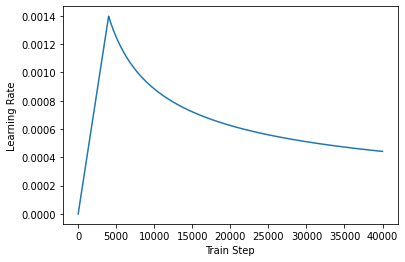

In [33]:
temp_learning_rate_schedule = CustomSchedule(d_model)

plt.plot(temp_learning_rate_schedule(tf.range(40000, dtype=tf.float32)))
plt.ylabel("Learning Rate")
plt.xlabel("Train Step")

In [34]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

In [35]:
def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask

  return tf.reduce_sum(loss_)/tf.reduce_sum(mask)


def accuracy_function(real, pred):
  accuracies = tf.equal(real, tf.argmax(pred, axis=2))

  mask = tf.math.logical_not(tf.math.equal(real, 0))
  accuracies = tf.math.logical_and(mask, accuracies)

  accuracies = tf.cast(accuracies, dtype=tf.float32)
  mask = tf.cast(mask, dtype=tf.float32)
  return tf.reduce_sum(accuracies)/tf.reduce_sum(mask)



In [38]:
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.Mean(name='train_accuracy')

In [39]:
transformer = Transformer(
    num_layers=num_layers,
    d_model=d_model,
    num_heads=num_heads,
    dff=dff,
    input_vocab_size=tokenizers.pt.get_vocab_size(),
    target_vocab_size=tokenizers.en.get_vocab_size(), 
    pe_input=1000, 
    pe_target=1000,
    rate=dropout_rate)

In [40]:
def create_padding_mask(seq):
  seq = tf.cast(tf.math.equal(seq, 0), tf.float32)

  # add extra dimensions to add the padding
  # to the attention logits.
  return seq[:, tf.newaxis, tf.newaxis, :]  # (batch_size, 1, 1, seq_len)

In [41]:
def create_look_ahead_mask(size):
  mask = 1 - tf.linalg.band_part(tf.ones((size, size)), -1, 0)
  return mask

In [42]:
def create_masks(inp, tar):
  # Encoder padding mask
  enc_padding_mask = create_padding_mask(inp)

  # Used in the 2nd attention block in the decoder.
  # This padding mask is used to mask the encoder outputs.
  dec_padding_mask = create_padding_mask(inp)

  # Used in the 1st attention block in the decoder.
  # It is used to pad and mask future tokens in the input received by 
  # the decoder.
  look_ahead_mask = create_look_ahead_mask(tf.shape(tar)[1])
  dec_target_padding_mask = create_padding_mask(tar)
  combined_mask = tf.maximum(dec_target_padding_mask, look_ahead_mask)

  return enc_padding_mask, combined_mask, dec_padding_mask

In [43]:
checkpoint_path = "./checkpoints/train"

ckpt = tf.train.Checkpoint(transformer=transformer,
                           optimizer=optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

# if a checkpoint exists, restore the latest checkpoint.
if ckpt_manager.latest_checkpoint:
  ckpt.restore(ckpt_manager.latest_checkpoint)
  print ('Latest checkpoint restored!!')

In [44]:
# The @tf.function trace-compiles train_step into a TF graph for faster
# execution. The function specializes to the precise shape of the argument
# tensors. To avoid re-tracing due to the variable sequence lengths or variable
# batch sizes (the last batch is smaller), use input_signature to specify
# more generic shapes.

train_step_signature = [
    tf.TensorSpec(shape=(None, None), dtype=tf.int64),
    tf.TensorSpec(shape=(None, None), dtype=tf.int64),
]


@tf.function(input_signature=train_step_signature)
def train_step(inp, tar):
  tar_inp = tar[:, :-1]
  tar_real = tar[:, 1:]

  enc_padding_mask, combined_mask, dec_padding_mask = create_masks(inp, tar_inp)

  with tf.GradientTape() as tape:
    predictions, _ = transformer(inp, tar_inp,
                                 True,
                                 enc_padding_mask,
                                 combined_mask,
                                 dec_padding_mask)
    loss = loss_function(tar_real, predictions)

  gradients = tape.gradient(loss, transformer.trainable_variables)
  optimizer.apply_gradients(zip(gradients, transformer.trainable_variables))

  train_loss(loss)
  train_accuracy(accuracy_function(tar_real, predictions))

In [45]:
for (batch, (inp, tar)) in enumerate(train_batches):
  print(inp)

Streaming output truncated to the last 5000 lines.
 [   2  122  137 ...    0    0    0]
 [   2  938   28 ...    0    0    0]
 [   2 5201   15 ...    0    0    0]], shape=(64, 58), dtype=int64)
tf.Tensor(
[[   2 6789 1020 ...    0    0    0]
 [   2   99   89 ...    0    0    0]
 [   2   59  343 ...    0    0    0]
 ...
 [   2   88   44 ...    0    0    0]
 [   2   99  120 ...    0    0    0]
 [   2   40  286 ...    0    0    0]], shape=(64, 119), dtype=int64)
tf.Tensor(
[[   2 2553 2929 ...    0    0    0]
 [   2   44   87 ...    0    0    0]
 [   2 1126 1299 ...    0    0    0]
 ...
 [   2  203  118 ...    0    0    0]
 [   2  103 2512 ...    0    0    0]
 [   2   39   39 ...    0    0    0]], shape=(64, 80), dtype=int64)
tf.Tensor(
[[  2  40 647 ...   0   0   0]
 [  2  44  84 ...   0   0   0]
 [  2 239  40 ...   0   0   0]
 ...
 [  2  88 282 ...   0   0   0]
 [  2  54 348 ...   0   0   0]
 [  2 115  92 ...   0   0   0]], shape=(64, 46), dtype=int64)
tf.Tensor(
[[  2  44 410 ...   0   

In [48]:
for epoch in range(EPOCHS):
  start = time.time()

  train_loss.reset_states()
  train_accuracy.reset_states()

  # inp -> portuguese, tar -> english
  for (batch, (inp, tar)) in enumerate(train_batches):
    train_step(inp, tar)

    if batch % 50 == 0:
      print(f'Epoch {epoch + 1} Batch {batch} Loss {train_loss.result():.4f} Accuracy {train_accuracy.result():.4f}')

  if (epoch + 1) % 5 == 0:
    ckpt_save_path = ckpt_manager.save()
    print(f'Saving checkpoint for epoch {epoch+1} at {ckpt_save_path}')

  print(f'Epoch {epoch + 1} Loss {train_loss.result():.4f} Accuracy {train_accuracy.result():.4f}')

  print(f'Time taken for 1 epoch: {time.time() - start:.2f} secs\n')

TypeError: ignored

In [ ]:
def evaluate(sentence, max_length=40):
  # inp sentence is portuguese, hence adding the start and end token
  sentence = tf.convert_to_tensor([sentence])
  sentence = tokenizers.pt.tokenize(sentence).to_tensor()

  encoder_input = sentence

  # as the target is english, the first word to the transformer should be the
  # english start token.
  start, end = tokenizers.en.tokenize([''])[0]
  output = tf.convert_to_tensor([start])
  output = tf.expand_dims(output, 0)

  for i in range(max_length):
    enc_padding_mask, combined_mask, dec_padding_mask = create_masks(
        encoder_input, output)

    # predictions.shape == (batch_size, seq_len, vocab_size)
    predictions, attention_weights = transformer(encoder_input, 
                                                 output,
                                                 False,
                                                 enc_padding_mask,
                                                 combined_mask,
                                                 dec_padding_mask)

    # select the last word from the seq_len dimension
    predictions = predictions[: ,-1:, :]  # (batch_size, 1, vocab_size)

    predicted_id = tf.argmax(predictions, axis=-1)

    # concatentate the predicted_id to the output which is given to the decoder
    # as its input.
    output = tf.concat([output, predicted_id], axis=-1)

    # return the result if the predicted_id is equal to the end token
    if predicted_id == end:
      break

  # output.shape (1, tokens)
  text = tokenizers.en.detokenize(output)[0] # shape: ()

  tokens = tokenizers.en.lookup(output)[0]

  return text, tokens, attention_weights